# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [13]:
#I choose AMT_ANNUITY for analysis
app_train['AMT_ANNUITY'].describe()

count    307511.000000
mean      27108.487841
std       14493.461065
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

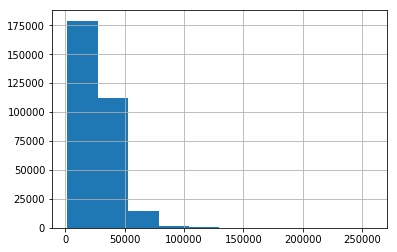

In [14]:
# First, use histagram to observe the distribution. It is right-bias distibution.
app_train['AMT_ANNUITY'].hist()

In [12]:
# Second, I fill the NA is the columns. Because the bias of distribution, I replace NA with median
app_train['AMT_ANNUITY'].fillna(value=app_train['AMT_ANNUITY'].median(), inplace=True)
app_train['AMT_ANNUITY'].isnull().sum()

0

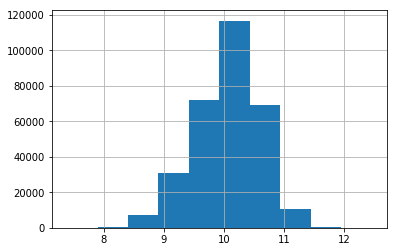

In [15]:
# Then, I use log1p to tranform the value, the distibution is more close to normal after transformation.
app_train['AMT_ANUUITY_LOG'] = np.log1p(app_train['AMT_ANNUITY'])
app_train['AMT_ANUUITY_LOG'].hist()

In [17]:
# I use pd.cut to discretizate the value into 10 group.
app_train['AMT_ANUUITY_LOG_DESC'] = pd.cut(app_train['AMT_ANUUITY_LOG'],10)

In [18]:
# Use groupby to find the mean of 'TARGET' in each group.
app_train.groupby('AMT_ANUUITY_LOG_DESC')['TARGET'].agg('mean')

AMT_ANUUITY_LOG_DESC
(7.383, 7.895]      0.000000
(7.895, 8.403]      0.058319
(8.403, 8.91]       0.062509
(8.91, 9.417]       0.070999
(9.417, 9.924]      0.079744
(9.924, 10.432]     0.090710
(10.432, 10.939]    0.076348
(10.939, 11.446]    0.051708
(11.446, 11.954]    0.026239
(11.954, 12.461]    0.000000
Name: TARGET, dtype: float64

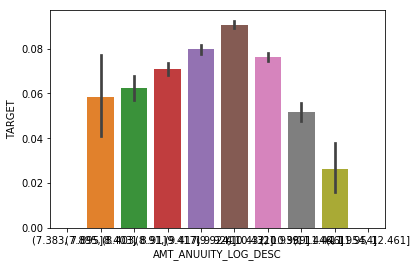

In [24]:
# Display the mean of TARGET value in barchart.
import seaborn as sns
px = app_train['AMT_ANUUITY_LOG_DESC']
py = app_train['TARGET']
sns.barplot(px, py)

In [25]:
# I find out that the group of (9.924, 10.432] with the highest ratio of 1 in 'TARGET'
# Transfer (9.924, 10.432] to real value
low = np.exp(9.924) -1
high = np.exp(10.432) -1
print("The group {} to {} has the highest ratio of 1 in TARGET".format(low,high))

The group 20413.48547185274 to 33927.13872663624 has the highest ratio of 1 in TARGET
